# HW 2 (due November 30 23:59 MSK)

### Problem 1 (1 points)

Diffie–Hellman key exchange protocol is one of the earliest practical examples of public key exchange implemented within the field of cryptography. Published in 1976 by Diffie and Hellman, this is the earliest publicly known work that proposed the idea of a private key and a corresponding public key. 

1. Implement function to generate common secret key within multiplicative group of given Finite field with known generator 

In [15]:
def generate(p, g, a, B):
    # s = B^a mod p
    return pow(B, a, p) # function that do exactly what we need from data that we are given

In [22]:
def log_gridsearch(g, B, p):
    # B = g^b mod p via gridsearch
    for i in range(p):
        if B == (g ** i) % p:
            return i
        
def public_from_private(g, a, p):
    return (g ** a) % p

2. Test your solution in GF(17) with generator g=11. Bobs' open key B=11, Alice private key is a=7

In [23]:
s = generate(17, 11, 7, 11) # reference easy way to compare with normal procedure
print(s)

3


In [24]:
b = log_gridsearch(11, 11, 17) # b from B, assuming we don't know a and и from the start, as in seminar example
A = public_from_private(11, 7, 17) # A = g^a mod p - getting A from a to check (A^b mod p) equals to (B^a mod p)
print(s == (A ** b) % 17) # if "True", then normal handmade search gives same result as simple straightforward "pow" method

True


### Problem 2 (3 points)

El Gamal protocol is widely used in cryptography. In this task we will ask you to implement your own El-Gamal encryption scheme on Python

1. Implement function for generating keys. The function must generate big random prime number (problem of generating big prime numbers was discussed within the lectures). (1 point)

In [3]:
from random import randint, randrange
import hashlib

In [4]:
def test_prime_fermat(n = 256, N = 512): # I didn't use it (as well as seminar's version), works slower
    
    flag_prime = False
    prime = 2 
    
    while not flag_prime:
        
        prime = randrange(2 ** (n - 1), 2 ** n) # generate big number
        
        for idx in range(1, N):
            if pow(idx, prime - 1, prime) != 1: # (i ^ [p - 1]) mod p
                flag_prime = False
        flag_prime = True
        print(idx)
    return prime
    

        
def test_prime_miller_rabin(prime, N = 100): # algorithm from wikipedia
            
    if prime % 2 != 0: # to exclude even numbers right away
            
        s = 0
        t = prime - 1
        
        while t % 2 == 0: # convert prime - 1 to form (2^s)*t
            s += 1
            t = t //2
                
        for _ in range(N):
                
            a = randrange(2, prime - 1)
            x = pow(a, t, prime) # (a ^ t) mod p
                
            if x == 1 or x == prime - 1:
                continue
                    
            for _ in range(s - 1):
                x = pow(x, 2, prime) # (x ^ 2) mod p
                if x == prime - 1:
                    break
                        
            else:
                return False
                    
        return True

def generate_keys(p):
    
    g = randint(1, p - 1)
    x = randint(1, p - 1)
    
    public = pow(g, x, p) # (y, g, p)
    private = x # (x, g, p)
    
    return public, private, g

2. Implement functions that realize the encryption and decryption in El Gamal protocol. (1 points)

In [5]:
def Encrypt(M, prime, g, public):
    
    assert M < prime - 1, 'Message is larger than prime number'

    k = randint(1, prime - 1)
    a = pow(g, k, prime)
       
    #b = ((public ** k) * M ) % p # bad idea to compute this with large 
    b = (pow(public, k, prime) * (M % prime)) % prime

    return a, b

def Decrypt(a, b, private, prime):
    #с = (b / a ** private) % p # again bad idea to compute this with large p
    
    # because of Fermat theorem we can add additional multiplier to power of 'a'
    с = (b * pow(a, prime - 1 - private, prime)) % prime 
    
    return с

3. Calculate Hash of your name by SHA-1 and test El Gamal encryption/decryption functions on it (1 points)

In [9]:
flag_prime = False
n = 200

while not flag_prime:
    p = randrange(2 ** (n - 1), 2 ** n) # generate big number
    flag_prime = test_prime_miller_rabin(p)

public, private, g = generate_keys(p)  

M = hashlib.sha1("AlexanderShumilov".encode('ascii')).hexdigest()
M_dec = int(M, 16)

a, b = Encrypt(M_dec, p, g, public)
M_decrypted = Decrypt(a, b, private, p)

In [14]:
print('Prime number: ', p)
print('Hashed name original: ', M)
print('Hashed name decimal: ', M_dec)
print('Hashed name decrypted: ', hex(M_decrypted)[2:])
print()

if hex(M_decrypted)[2:] == M:
    print('Encryption and Decryption processes are correct')
else:
    print('Encryption and Decryption processes are incorrect, something went wrong')

Prime number:  918357683008465178011769129376918789290420065664111527647691
Hashed name original:  7bfb22e00b3c0df78856c0a56d0d8660aab16076
Hashed name decimal:  707806389912068647075825954720867456291485868150
Hashed name decrypted:  7bfb22e00b3c0df78856c0a56d0d8660aab16076

Encryption and Decryption processes are correct


### Problem 3 (3 points)

Elliptic curves due to their efficient hardware realization widely used in modern secure communication channels. The main thing that lies inside their cryptographic hardness is that we can break them only by greed search over all group points. In this task, we will ask you to write python function that returns all group elements of a certain elliptic curve over a finite field 

1. Write a python function that list all points of elliptic curve $y^2=x^3-5x-8$ over $F_{11}$ (2 points)

In [5]:
import matplotlib.pyplot as plt

def list_points(p, q, prime): # y^2 = x^3 - px - q -> p = 5, q = 8
    
    rhs_list = []
    lhs_list = []
    point_list = []
    
    i_list = []
    j_list = []
    
    # Good video: https://www.youtube.com/watch?v=_QR-kTypf4E&ab_channel=LecturesbyShreedarshanK
    # Nice material 1: https://jeremykun.com/2014/02/08/introducing-elliptic-curves/
    # Nice material 2: https://habr.com/ru/post/335906/
    # Nice material 3: http://www.pdmi.ras.ru/~lowdimma/BSD/Silverman-Arithmetic_of_EC.pdf
    
    for i in range(prime):
        rhs_list.append((i**3 - p*i - q) % prime) # RHS (x^3 - px - q) mod prime for x in [0, prime - 1]
        lhs_list.append((i**2) % prime) # LHS (y^2) mod prime for y in [0, prime - 1]
        
    for i in range(len(rhs_list)):
        for j in range(len(lhs_list)):
            if rhs_list[i] == lhs_list[j]: # If mod results are equal, then point lies on curve
                point_list.append((i, j))
                i_list.append(i)
                j_list.append(j)
                
    plt.scatter(i_list, j_list)            
    return point_list

Points of elliptic curve:  [(0, 5), (0, 6), (2, 1), (2, 10), (3, 2), (3, 9), (4, 5), (4, 6), (5, 2), (5, 9), (7, 5), (7, 6), (9, 4), (9, 7)]


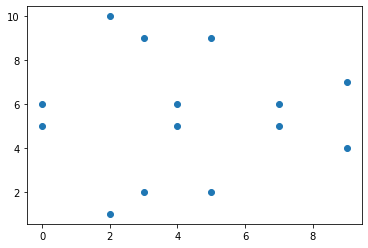

In [6]:
points = list_points(5, 8, 11)
print('Points of elliptic curve: ', points) 

# I checked my solution (which is correct) here: https://graui.de/code/elliptic2/
# 'Infinity' point O wasn't included but was taken into account in

2. Compute the sum of two points in group above and make sure that result lies within the same group (1 point)

In [7]:
# Part of find_inverse below - seminar code
# See: http://en.wikipedia.org/wiki/Extended_Euclidean_algorithm
def eea(a,b):
    if b==0:return (1,0)
    (q,r) = (a//b,a%b)
    (s,t) = eea(b,r)
    return (t, s-(q*t) )

# Find the multiplicative inverse of x (mod y)
# see: http://en.wikipedia.org/wiki/Modular_multiplicative_inverse
def find_inverse(x,y):
    inv = eea(x,y)[0]
    if inv < 1: inv += y #we only want positive values
    return inv

# https://www.youtube.com/watch?v=NTztut15D2E&t=526s&ab_channel=AdvancedMaths
def find_slope(P, Q, prime): # slope (tangent) of line PQ
    
    x_P = P[0]
    y_P = P[1]
    
    x_Q = Q[0]
    y_Q = Q[1]
    
    if x_P == x_Q and y_P == y_Q: # Special case (P = Q)
        sl = ((3 * x_P**2 - p) * find_inverse(2*y_P, prime))  # instead of division we must use inversion - very important
        
    else: # Ordinary case handling 
        sl = ((y_P - y_Q) * find_inverse(x_P - x_Q, prime))  
    
    return sl % prime 

def add_points(P, Q, p, prime): # We assume that these points already belong to curve and no need to check that
    
    x_P = P[0]
    y_P = P[1]
    
    x_Q = Q[0]
    y_Q = Q[1]
    '''
    if y_P == - y_Q:
        return 0 # 'infinity' point
    ''' 
    if x_P == x_Q and (y_P + y_Q) % prime == 0:
        return 0 # 'infinity' point
    
    sl = find_slope(P, Q, prime)
        
    x_R = sl**2 - x_P - x_Q
    y_R = sl * (x_P - x_R) - y_P
    
    x_R_result = x_R % prime
    y_R_result = y_R % prime
    
    return x_R_result, y_R_result

In [8]:
flag = True
for idx, point_pair_1 in enumerate(points):
    for point_pair_2 in points[idx + 1:]:
        R = add_points(point_pair_1, point_pair_2, 5, 11)
        if R not in points:
            if R != 0: # in this case we get 'infinity point' O and it is okay
                print('Sum of points {} and {} does not lie in group F(11)'.format(point_pair_1, point_pair_2))
                flag = False
            
if flag:
    print('Results of summations for all pair of points gives correct result')

Results of summations for all pair of points gives correct result


### Problem 4 (3 points)

Merkle hash trees play an important role in forming transaction blocks in blockchain. In this assignment we ask you to plot your own Merkle hash tree and check its' properties. Below we provide you with some code fragment what you can use in your assignment

In [14]:
import matplotlib
import networkx as nx
%matplotlib qt5 # draws in new window
#%matplotlib inline

from networkx import balanced_tree, draw_networkx, draw

Let us plot graph basis for Merkle hash tree

{0: Text(0, 4, '0'),
 1: Text(-2, 3, '1'),
 2: Text(2, 3, '2'),
 3: Text(-3, 2, '3'),
 4: Text(-1, 2, '4'),
 5: Text(1, 2, '5'),
 6: Text(3, 2, '6'),
 7: Text(-3, 1, 'tx1'),
 8: Text(-1, 1, 'tx2'),
 9: Text(1, 1, 'tx3'),
 10: Text(3, 1, 'tx4')}

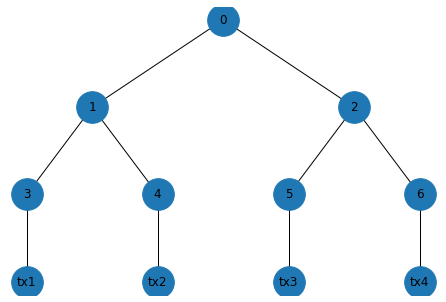

In [15]:
G = nx.Graph()
positions = {}
coordinates = [
    [0, 4],
    [-2, 3],
    [2, 3],
    [-3, 2],
    [-1, 2],
    [1, 2],
    [3, 2],
    [-3, 1],
    [-1, 1],
    [1, 1],
    [3, 1]
]
parents = [0, 0, 0, 1, 1, 2, 2, 3, 4, 5, 6]
for index in range(11):
    G.add_node(index)
    G.add_edge(index, parents[index])
    positions[index] = coordinates[index]
nx.draw(G, positions, node_size = 1000)
labels = {
    0: '0',
    1: '1',
    2: '2',
    3: '3',
    4: '4',
    5: '5',
    6: '6',
    7: 'tx1',
    8: 'tx2',
    9: 'tx3',
    10: 'tx4',
}
nx.draw_networkx_labels(G, positions, labels = labels)

In Bitcoin double sha256 hash scheme is used. Here is an example.

In [16]:
import hashlib


first_hash = hashlib.sha256(b"hello") # "b" stands for binary representation
second_hash = hashlib.sha256()
print('First hash represented as a hexadecimal number:', first_hash.hexdigest())
second_hash.update(first_hash.digest())
print('Second hash represented as a hexadecimal number:', second_hash.hexdigest())

First hash represented as a hexadecimal number: 2cf24dba5fb0a30e26e83b2ac5b9e29e1b161e5c1fa7425e73043362938b9824
Second hash represented as a hexadecimal number: 9595c9df90075148eb06860365df33584b75bff782a510c6cd4883a419833d50


Now we can easily change vertices' labels to hashes of corresponding messages and plot new graph

856a4921cd32690244af7568e7bd1391a94119e17c7f33234f4bf11271b223e5


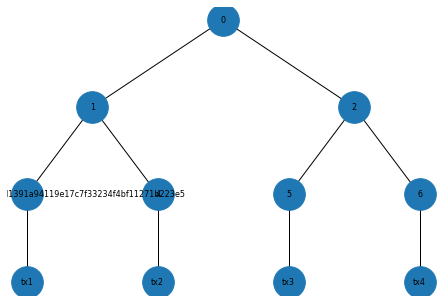

In [17]:
labels[3] = hashlib.sha256(hashlib.sha256(b"tx1").digest()).hexdigest()

# and plot the graph again

nx.draw(G, positions, node_size = 1000)
nx.draw_networkx_labels(G, positions, labels = labels, font_size = 8)
print(labels[3])

1. Construct Merkle hash tree using previously constructed graph by finding corresponding SHA256 hashes on vertices and plot obtained Merkle hash tree (1 point)

In [18]:
def hash256(vertice): # Hashing
    return hashlib.sha256(hashlib.sha256(vertice.encode('ascii')).digest()).hexdigest()

{0: Text(0, 4, '5eaee129fb6c4761a542e919f8fd0fa3f3c3d83a33bbeeec5a7e8772ddfb8f88'),
 1: Text(-2, 3, '41925fc3630f375e23755f04099f1b2c51f372a9792762b28478fbbc5faf1106'),
 2: Text(2, 3, '5c72c2fc6c2ed732c66fa8dc63f163617be1eb6175b88b3b640f440abb236e73'),
 3: Text(-3, 2, '856a4921cd32690244af7568e7bd1391a94119e17c7f33234f4bf11271b223e5'),
 4: Text(-1, 2, '79043a4d1d4d6d0b830519bfc07b92b4d162a4cd54235719c2c3cc211a638dfd'),
 5: Text(1, 2, 'ef729c31d206229249bd791b29676d26cc7465aa6bc2003d80c7a82a316e0233'),
 6: Text(3, 2, '4746dc9c16f97469fa45710394c4a0e2f29226efc04cab47c29ce579ae19a74e'),
 7: Text(-3, 1, 'tx1'),
 8: Text(-1, 1, 'tx2'),
 9: Text(1, 1, 'tx3'),
 10: Text(3, 1, 'tx4')}

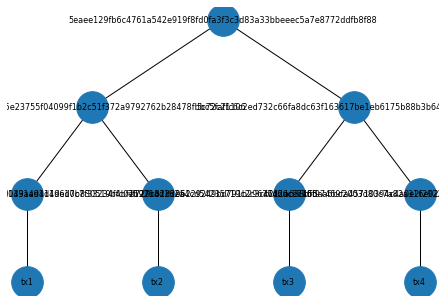

In [19]:
for i in range(3, 7): # 3,4,5,6
    labels[i] = hash256("tx"+str(i - 2))

labels[1] = hash256(labels[3] + labels[4])
labels[2] = hash256(labels[5] + labels[6])
labels[0] = hash256(labels[1] + labels[2])

nx.draw(G, positions, node_size = 1000)
nx.draw_networkx_labels(G, positions, labels = labels, font_size = 8)

2. Provide a proof of correctness of leaf tx1 and set of leafs tx1-tx2 (1 point)

Here we need to calculate hashes of vertices corresponding to tx1 and tx2 (so 3rd and 4th), then calculate hash of vertice 1, then calculate hash of vertices (1 + 2) and compare to value of vertice 0. If we will get 'True', then everything is right. Same for tx_1

In [20]:
#  tx_1
labels[3] = hash256("tx1")
labels[1] = hash256(labels[3] + labels[4])

print(labels[0] == hash256(labels[1] + labels[2]))

# tx_1 & tx_2
for i in range(3, 4): # 3,4 -> tx1, tx2
    labels[i] = hash256("tx"+str(i - 2))
    
labels[1] = hash256(labels[3] + labels[4])
print(labels[0] == hash256(labels[1] + labels[2]))

True
True


3. Change the value on leaf tx1 and recompute corresponding hashes. Plot newly obtained Merkle hash tree (1 point)

{0: Text(0, 4, 'faa4ab1f0c09cf093696874e29e0c5ed2e3d8e3371eca8bf2e373dc12de48755'),
 1: Text(-2, 3, '1582229e2ebc3723f1d7d9925549938ecf13a1f1614d2f7f02ac57bdee5d852b'),
 2: Text(2, 3, '5c72c2fc6c2ed732c66fa8dc63f163617be1eb6175b88b3b640f440abb236e73'),
 3: Text(-3, 2, '01497f2897652898bc310401b8f4f8d40f278e715a62f39eba5460551b2d144d'),
 4: Text(-1, 2, '79043a4d1d4d6d0b830519bfc07b92b4d162a4cd54235719c2c3cc211a638dfd'),
 5: Text(1, 2, 'ef729c31d206229249bd791b29676d26cc7465aa6bc2003d80c7a82a316e0233'),
 6: Text(3, 2, '4746dc9c16f97469fa45710394c4a0e2f29226efc04cab47c29ce579ae19a74e'),
 7: Text(-3, 1, 'tx1AlexanderShumilov'),
 8: Text(-1, 1, 'tx2'),
 9: Text(1, 1, 'tx3'),
 10: Text(3, 1, 'tx4')}

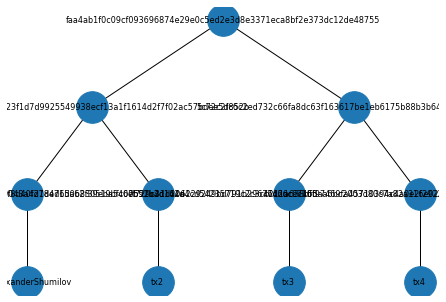

In [21]:
# print(labels)

new_tx = "tx1AlexanderShumilov"

labels[3] = hash256(new_tx)
labels[1] = hash256(labels[3] + labels[4]) # Vertice 1 and 0 will change, other vertices will not
labels[0] = hash256(labels[1] + labels[2])

labels[7] = new_tx # change label of labels[3] descendant

nx.draw(G, positions, node_size = 1000)
nx.draw_networkx_labels(G, positions, labels = labels, font_size = 8)